In [1]:
# compare the data/mc for cluster shape/position, variables used for BDT training
# to make sure the bdt is not just learning about the difference between data/mc

import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, make_ratio_plot

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2

# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [39]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()
year = 2018
category = 0
sig_ver = 'v4'
singleMuon = True
if singleMuon:
    data_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2016/v5/v5/normalized/'
else:
    data_path = '/mnt/hadoop//store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2018/v1/v29/normalized/'
sig_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall18/v1/'+sig_ver+'/normalized/'
lumi = (5.632467289 +2.572903489 +1.685313225 +3.988453305 +3.068943620 +3.527270568 +8.609721915) * 1000
print("lumi is "+str(round(lumi/1000,2))+" fb-1")
fpath_bkg['mc'] = sig_path+"ZH_HToSSTobbbb_ms55_1pb_weighted.root"
# bkg_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall18/v1/v3/normalized/'

# fpath_bkg['mc_bkg'] = bkg_path+"WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted.root"


if singleMuon:
    fpath_bkg['data'] = data_path+"Run2_displacedJetMuonNtupler_V1p17_Data2018_17Sept2018_Run2018-ZMu-17Sep2018_goodLumi.root"
    fpath_bkg['data'] = data_path+"Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016-ZMu-07Aug17_goodLumi.root"
else:
    fpath_bkg['data'] = data_path+"Run2_displacedJetMuonNtupler_V1p15_Data2016_Data2017_Data2018-HighMET_goodLumi.root"


# fpath_bkg['data'] = data_path+"Run2_displacedJetMuonNtupler_V1p17_Data2016_Data2017_Data2018-ZMu_goodLumi.root"



# fpath_bkg['data'] = data_path+"Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016-ZMu-07Aug17_goodLumi.root"


    

lumi is 29.09 fb-1


In [40]:
for k,v in fpath_bkg.items():
    print (k, v)
    root_dir = uproot.open(v) 
    tree_bkg[k] = root_dir['MuonSystem']
    a = tree_bkg[k]["weight"].array()
    print (np.unique(a)*lumi)
    print(a.shape)

mc /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall18/v1/v4/normalized/ZH_HToSSTobbbb_ms55_1pb_weighted.root
[-0.00856734 -0.00841917  0.00841917  0.00856734]
(110259,)
data /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2016/v5/v5/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016-ZMu-07Aug17_goodLumi.root
[29085.074]
(4102310,)


In [11]:
phi_corr_lst = [ 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.80, 0.85 ]
r_corr_lst = [ 1.05, 1.1, 1.15, 1.2, 1.25, 1.3 ]



In [12]:
import math
def deltaPhi( phi1,  phi2):
    dphi = phi1-phi2
    while (dphi > math.pi):
        dphi -= 2*math.pi
    while (dphi <= -math.pi):
        dphi += 2*math.pi
    return dphi
def deltaR(eta1, phi1, eta2, phi2):
    dphi = deltaPhi(phi1,phi2)
    deta = eta1 - eta2
    return (dphi*dphi + deta*deta)**0.5

# load BDT

In [13]:
import pandas as pd
import pickle

bdt_model = 2
# if bdt_model == 0:
#     model = pickle.load(open( 'bdt_flatten_metfilter_me1112nohits_eta2p1.pickle', "rb" ))
# elif bdt_model == 1:
#     model = pickle.load(open( 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs.pickle', "rb" ))
# else:
bdt_name = 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_XYspread_v12'
model = pickle.load(open(bdt_name+'.pickle', "rb" ))
bdt_cut = 0.50882477


0.75 1.2 1
mc_bkg 3269
3269
values missing:  False
mc_signal 20832
20832
values missing:  False
data 221225
221225
values missing:  False
30 30 30 30
max reweight 1974.0404 9433.308
max reweight 1974.0404 9433.308
max reweight 1974.0404 9433.308
max reweight 1974.0404 9433.308
max reweight 1974.0404 9433.308
max reweight 1974.0404 9433.308
max reweight 1974.0404 9433.308
max reweight 1974.0404 9433.308
max reweight 1974.0404 9433.308
max reweight 1974.0404 9433.308
max reweight 1974.0404 9433.308
max reweight 1974.0404 9433.308
max reweight 1974.0404 9433.308
max reweight 1974.0404 9433.308
max reweight 1974.0404 9433.308
max reweight 1974.0404 9433.308
max reweight 1974.0404 9433.308
max reweight 1974.0404 9433.308
max reweight 1974.0404 9433.308
max reweight 1974.0404 9433.308
max reweight 1974.0404 9433.308
max reweight 1974.0404 9433.308
max reweight 1974.0404 9433.308
max reweight 1974.0404 9433.308
max reweight 1974.0404 9433.308
max reweight 1974.0404 9433.308
max reweight 1974.

Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: mc_bkg (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: mc_bkg (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: mc_bkg (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: mc_signal (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Info in <TCanvas::Print>: png file /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/MCData_shape_comparison_SingleMuon_XYspread_12_muonShowerv1p17v4_eta0p8to2p0/ZMass_withRatio_muonPt50_cscRechitCluster2IsoMuonVetoEReweight_phi0p75_r1p2.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/MCData_shape_comparison_SingleMuon_XYspread_12_muonShowerv1p17v4_eta0p

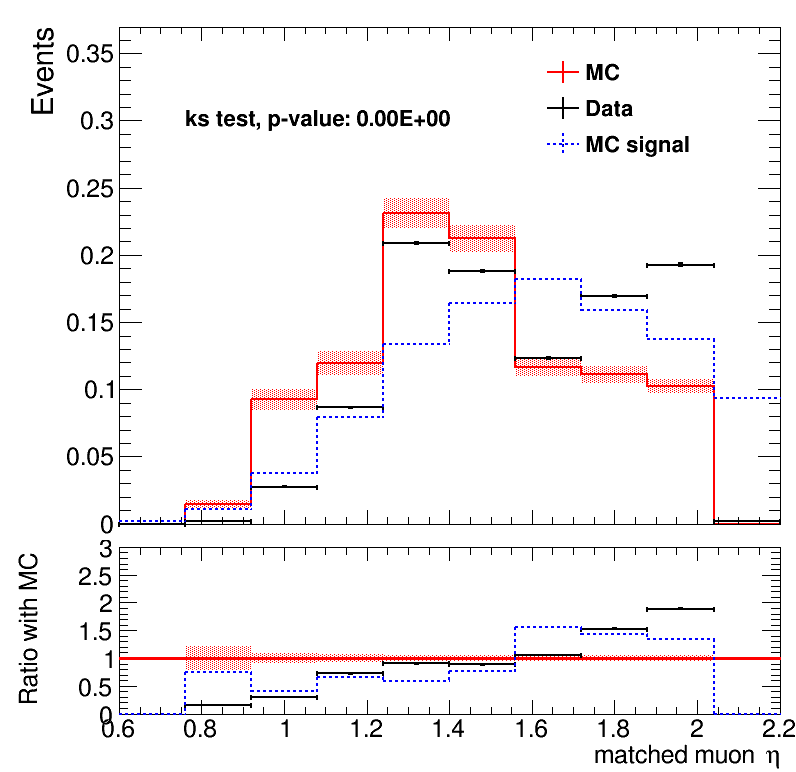

In [64]:
%%time

           
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
import os
start_t = time.time()
jetPt_cut = 50
tightid = False
evtNum  = {}
lumiSec = {}
runNum = {}


pileupWeight = {}
weight = {}
npv = {}
npu = {}
nJets = {}
nJets_50gev = {}
jetPt = {}
jetPhi = {}
jetEta = {}
metPhi = {}
met = {}
jetMet_dPhiMin4 = {}
nJets = {}
jetPhi = {}
jetPt = {}
cscRechitClusterJetPhi = {}
cscRechitClusterXSpread = {}
cscRechitClusterYSpread = {}
cscRechitClusterZSpread = {}
cscRechitClusterEtaSpread = {}
cscRechitClusterPhiSpread = {}
cscRechitClusterEtaPhiSpread = {}
dphiMet_cluster = {}
cscRechitClusterX = {}
cscRechitClusterY = {}
cscRechitClusterZ = {}
cscRechitClusterR = {}
cscRechitClusterEta = {}
cscRechitClusterPhi = {}
cscRechitClusterNStation = {}
cscRechitClusterNStation5 = {}
cscRechitClusterNStation10perc = {}
cscRechitClusterAvgStation = {}
cscRechitClusterAvgStation5 = {}
cscRechitClusterAvgStation10perc = {}
cscRechitClusterMaxStation = {}

cscRechitClusterXYSpread = {}
cscRechitClusterRSpread = {}
cscRechitClusterSize = {}
cscRechitCluster2JetVetoPt = {}
cscRechitCluster2IsoMuonVetoPt = {}
cscRechitCluster2IsoMuonVetoE = {}
cscRechitCluster2IsoMuonVetoEta = {}
cscRechitClusterTimeSpread = {}
jetMet_dPhiMin = {}
bdt_score = {}
ZMass = {}
datasets = {}
keys = ['mc_bkg', 'mc_signal', 'data']
# keys = ['mc_bkg_corr', 'mc_signal', 'data']


# phi_corr = '0p7'
# r_corr = '1p2'
r_corr_flag = 1
eta0 = 0.8
eta1 = eta0 + 1.2
muonPt = 50

for phi_corr_i, phi_corr in enumerate(phi_corr_lst):
    for r_corr_i, r_corr in enumerate(r_corr_lst):
        if eta0 == 0.8 and not(phi_corr==0.75 and r_corr==1.2): continue
        if eta0 == 1.0 and not(phi_corr==0.7 and r_corr==1.15): continue
        if eta0 == 1.2 and not(phi_corr==0.6 and r_corr==1.1): continue
        if eta0 == 1.4 and not(phi_corr==0.55 and r_corr==1.1): continue
        if eta0 == 1.6 and not(phi_corr==0.75 and r_corr==1.1): continue
        if eta0 == 1.8 and not(phi_corr==0.75 and r_corr==1.05): continue

        print(phi_corr, r_corr, r_corr_flag)
        for k in keys:
            if 'mc' in k: T = tree_bkg['mc']
            else: T = tree_bkg[k]
#             T = tree_bkg[k]
            sel_cluster = np.abs(T.array('cscRechitCluster2Time')) < 12.5
            sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2Size'))>=50)
            sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2TimeSpread'))<20)
            sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2MaxChamber')) > 12)
            
            sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2Eta')) >= eta0)
            sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2Eta')) < eta1)    
            if k == 'mc_signal':
                sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitCluster2_match_gLLP') == 1)
                sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitCluster2_match_gLLP_csc') == 1)
            else:
                sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2MuonVetoPt')) > muonPt)
                sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2MuonVetoPt')) < 2000)
                sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2MuonVetoTightIso')) == 1)
                sel_cluster = np.logical_and(sel_cluster, np.logical_or(T.array('cscRechitCluster2ZLep1') == 1, T.array('cscRechitCluster2ZLep2') == 1))
                if k == 'mc_bkg':
                    sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitCluster2_match_gLLP') == 0) 
                    sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitCluster2GenMuonVetoPt') > muonPt)
                    sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitCluster2GenMuonVetoPt') < 2000)


                elif k == 'data':
        #             sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2Met_dPhi')) < 1)
                    if singleMuon: 
                        sel_cluster = np.logical_and(sel_cluster, np.logical_or(T.array('cscRechitCluster2ZLep1') == 1, T.array('cscRechitCluster2ZLep2') == 1))
                    else: 
                        sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2Met_dPhi')) < 2.5)
        

        # ########### BRANCHES ############
            sel_ev = sel_cluster.sum() ==1 
            if k == 'data':
                sel_ev = np.logical_and(sel_ev, T.array("Flag2_all"))
                if singleMuon: sel_ev = np.logical_and(sel_ev, T.array('category')==2)
                else: sel_ev = np.logical_and(sel_ev, np.abs(T.array('jetMet_dPhiMin'))>2)
            if not k == 'mc_signal':
                sel_ev = np.logical_and(sel_ev, T.array('category')==2)
                sel_ev = np.logical_and(sel_ev, T.array('ZMass')>=60)


#                 sel_ev = np.logical_and(sel_ev, (T.array('lepPassId')==1).sum()==2) #require both muons to pass tight id
            print(k, np.count_nonzero(sel_ev))
        #     if k == 'data': sel_ev = np.logical_and(sel_ev, T.array('jetMet_dPhiMin')>1)

        #     if 'mc' in k:
        #         gLLP_decay_vertex_z = T.array('gLLP_decay_vertex_z')
        #         gLLP_decay_vertex_r = T.array('gLLP_decay_vertex_r')
        #         distance0 = np.sqrt(gLLP_decay_vertex_z[:,0]**2+gLLP_decay_vertex_r[:,0]**2)
        #         distance1 = np.sqrt(gLLP_decay_vertex_z[:,1]**2+gLLP_decay_vertex_r[:,1]**2)
        #         cond1 = np.logical_or(distance1<200, np.logical_or(gLLP_decay_vertex_z[:,1]>1100, gLLP_decay_vertex_r[:,1]>800))
        #         cond0 = np.logical_or(distance0<200, np.logical_or(gLLP_decay_vertex_z[:,0]>1100, gLLP_decay_vertex_r[:,0]>800))
        #         sel_ev = np.logical_and(sel_ev, np.logical_and(cond0, cond1))
            print(np.count_nonzero(sel_ev))
            cscRechitClusterXSpread[k] = T.array('cscRechitCluster2XSpread')[sel_cluster][sel_ev][:,0]
            cscRechitClusterYSpread[k] = T.array('cscRechitCluster2YSpread')[sel_cluster][sel_ev][:,0]
            cscRechitClusterZSpread[k] = T.array('cscRechitCluster2ZSpread')[sel_cluster][sel_ev][:,0]
            cscRechitClusterEtaSpread[k] = T.array('cscRechitCluster2EtaSpread')[sel_cluster][sel_ev][:,0]
            cscRechitClusterPhiSpread[k] = T.array('cscRechitCluster2PhiSpread')[sel_cluster][sel_ev][:,0]
            cscRechitClusterXYSpread[k] = T.array('cscRechitCluster2XYSpread')[sel_cluster][sel_ev][:,0]
            cscRechitClusterRSpread[k] = T.array('cscRechitCluster2RSpread')[sel_cluster][sel_ev][:,0]
            cscRechitClusterEtaPhiSpread[k] = T.array('cscRechitCluster2EtaPhiSpread')[sel_cluster][sel_ev][:,0]
            if 'mc' in k and r_corr_flag:
                cscRechitClusterXSpread[k] = T.array('cscRechitCluster2XSpread_corr')[:,:,phi_corr_i,r_corr_i][sel_cluster][sel_ev][:,0]
                cscRechitClusterYSpread[k] = T.array('cscRechitCluster2YSpread_corr')[:,:,phi_corr_i,r_corr_i][sel_cluster][sel_ev][:,0]
                cscRechitClusterXYSpread[k] = T.array('cscRechitCluster2XYSpread_corr')[:,:,phi_corr_i,r_corr_i][sel_cluster][sel_ev][:,0]
                cscRechitClusterEtaPhiSpread[k] = T.array('cscRechitCluster2EtaPhiSpread_corr')[:,:,phi_corr_i,r_corr_i][sel_cluster][sel_ev][:,0]
                cscRechitClusterEtaSpread[k] = T.array('cscRechitCluster2EtaSpread_corr')[:,:,phi_corr_i,r_corr_i][sel_cluster][sel_ev][:,0]
                cscRechitClusterPhiSpread[k] = T.array('cscRechitCluster2PhiSpread_corr')[:,:,phi_corr_i,r_corr_i][sel_cluster][sel_ev][:,0]
                cscRechitClusterRSpread[k] = T.array('cscRechitCluster2RSpread_corr')[:,:,phi_corr_i,r_corr_i][sel_cluster][sel_ev][:,0]
             
        
            
            cscRechitClusterX[k] = T.array('cscRechitCluster2X')[sel_cluster][sel_ev][:,0]
            cscRechitClusterY[k] = T.array('cscRechitCluster2Y')[sel_cluster][sel_ev][:,0]
            cscRechitClusterR[k] = ((T.array('cscRechitCluster2X')**2+T.array('cscRechitCluster2Y')**2)**0.5)[sel_cluster][sel_ev][:,0]
            cscRechitClusterZ[k] = T.array('cscRechitCluster2Z')[sel_cluster][sel_ev][:,0]
            cscRechitClusterEta[k] = T.array('cscRechitCluster2Eta')[sel_cluster][sel_ev][:,0]
            cscRechitClusterPhi[k] = T.array('cscRechitCluster2Phi')[sel_cluster][sel_ev][:,0]
            cscRechitClusterSize[k] = T.array('cscRechitCluster2Size')[sel_cluster][sel_ev][:,0]
            cscRechitClusterTimeSpread[k] = T.array('cscRechitCluster2TimeSpread')[sel_cluster][sel_ev][:,0]

            cscRechitCluster2IsoMuonVetoPt[k] = T.array('cscRechitCluster2MuonVetoPt')[sel_cluster][sel_ev][:,0]
            cscRechitCluster2IsoMuonVetoE[k] = T.array('cscRechitCluster2MuonVetoE')[sel_cluster][sel_ev][:,0]
            cscRechitCluster2IsoMuonVetoEta[k] = T.array('cscRechitCluster2MuonVetoEta')[sel_cluster][sel_ev][:,0]
            dphiMet_cluster[k] = np.abs(T.array('cscRechitCluster2Met_dPhi'))[sel_cluster][sel_ev][:,0]
            cscRechitCluster2JetVetoPt[k] = T.array('cscRechitCluster2JetVetoPt')[sel_cluster][sel_ev][:,0]
            
            cscRechitClusterNStation[k] = T.array('cscRechitCluster2NStation')[sel_cluster][sel_ev][:,0]
            cscRechitClusterNStation5[k] = T.array('cscRechitCluster2NStation5')[sel_cluster][sel_ev][:,0]
            cscRechitClusterNStation10perc[k] = T.array('cscRechitCluster2NStation10perc')[sel_cluster][sel_ev][:,0]
            cscRechitClusterAvgStation[k] = T.array('cscRechitCluster2AvgStation')[sel_cluster][sel_ev][:,0]
            cscRechitClusterAvgStation5[k] = T.array('cscRechitCluster2AvgStation5')[sel_cluster][sel_ev][:,0]
            cscRechitClusterAvgStation10perc[k] = T.array('cscRechitCluster2AvgStation10perc')[sel_cluster][sel_ev][:,0]
            cscRechitClusterMaxStation[k] = T.array('cscRechitCluster2MaxStation')[sel_cluster][sel_ev][:,0]

        
            ##### bdt variables ####
            if bdt_name=='bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_XYspread_v11':
                bdt_var = {'cscRechitClusterNStation': cscRechitClusterNStation5[k],
                'cscRechitClusterXSpread': cscRechitClusterXSpread[k],
                'cscRechitClusterYSpread':cscRechitClusterYSpread[k],
                'cscRechitClusterXYSpread':cscRechitClusterXYSpread[k],
                'cscRechitClusterPhi':np.abs(cscRechitClusterPhi[k]),
                'cscRechitClusterEta':np.abs(cscRechitClusterEta[k]),
                'cscRechitClusterZ':np.abs(cscRechitClusterZ[k]),
                }
            elif bdt_name=='bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_XYspread_v12':
                bdt_var = {'cscRechitClusterNStation': cscRechitClusterNStation5[k],
                'cscRechitClusterXSpread': cscRechitClusterXSpread[k],
                'cscRechitClusterYSpread':cscRechitClusterYSpread[k],
                'cscRechitClusterXYSpread':cscRechitClusterXYSpread[k],
                'cscRechitClusterPhi':np.abs(cscRechitClusterPhi[k]),
                'cscRechitClusterEta':np.abs(cscRechitClusterEta[k]),
                'cscRechitClusterAvgStation5':np.abs(cscRechitClusterAvgStation5[k]),
                }
            else:
                print('BDT NOT FOUND')
            dataset = pd.DataFrame(bdt_var)
            print("values missing: ", dataset.isnull().values.any())
            datasets[k] = dataset

            bdt_score[k] = model.predict_proba(dataset.values)[:, 1] 
            met[k] = T.array('met') [sel_ev]
            metPhi[k] = T.array('metPhi')[sel_ev]
            npv[k] = T.array('npv')[sel_ev]
            weight[k] = T.array('weight')[sel_ev]*lumi
            pileupWeight[k] = T.array('pileupWeight')[sel_ev]
            jetMet_dPhiMin[k] = T.array('jetMet_dPhiMin')[sel_ev]

            nJets[k] = T.array('nJets')[sel_ev]
            jetPhi[k] = T.array('jetPhi')[sel_ev]
            jetPt[k] = T.array('jetPt')[sel_ev]
            evtNum[k] = T.array('evtNum')[sel_ev]
            lumiSec[k] = T.array('lumiSec')[sel_ev]
            runNum[k] = T.array('runNum')[sel_ev]
            ZMass[k]= T.array('ZMass')[sel_ev]


            if k == 'data':
                pileupWeight[k] = pileupWeight[k] * 0.0 + 1.0
                weight[k] = weight[k] * 0.0 + 1.0

        # Plotting ncsc
        reweight_flag =1
        logy = 0
        ks_prob = []


        if r_corr_flag: ks_prob_str = "phi"+str(phi_corr).replace(".", "p")+"_r"+str(r_corr).replace(".", "p")+'\t'
        else: ks_prob_str = "phi"+str(phi_corr).replace(".", "p")+'\t'

        rt.gStyle.SetOptFit(1011)
        if singleMuon:
            dir_name = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/MCData_shape_comparison_SingleMuon_XYspread_'+bdt_name[-2:]+'_muonShowerv1p17'+sig_ver+'_eta'+\
            str(eta0).replace(".", "p")+'to'+str(round(eta1,1)).replace(".", "p")+'/'
        else:
#             dir_name = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/MCData_shape_comparison_MET_XYspread_'+bdt_name[-2:]+'_muonShower'+sig_ver+'_eta'+\
#             str(eta0).replace(".", "p")+'to'+str(round(eta1,1)).replace(".", "p")+'/'
            dir_name = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/MCData_shape_comparison_MET_dphi2p5_XYspread_'+bdt_name[-2:]+'_muonShower'+sig_ver+'_eta'+\
        str(eta0).replace(".", "p")+'to'+str(round(eta0+0.2,1)).replace(".", "p")+'/'

        if not os.path.isdir(dir_name):os.makedirs(dir_name)
        var = [ZMass, cscRechitClusterNStation, cscRechitClusterNStation5, cscRechitClusterNStation10perc, cscRechitClusterAvgStation, cscRechitClusterAvgStation5, cscRechitClusterAvgStation10perc,\
    cscRechitClusterMaxStation, dphiMet_cluster, jetMet_dPhiMin, cscRechitClusterSize, bdt_score, cscRechitClusterEta, cscRechitClusterPhi, \
       cscRechitClusterX, cscRechitClusterY, cscRechitClusterZ, cscRechitClusterR, \
           cscRechitClusterEtaSpread, cscRechitClusterPhiSpread, cscRechitClusterEtaPhiSpread, cscRechitClusterRSpread, cscRechitClusterXSpread, cscRechitClusterYSpread, cscRechitClusterZSpread, \
               cscRechitClusterTimeSpread, cscRechitClusterXYSpread, cscRechitCluster2IsoMuonVetoPt, cscRechitCluster2IsoMuonVetoE, cscRechitCluster2IsoMuonVetoEta]
        title = ['Z mass [GeV]','N_{station}', 'N_{station}', 'N_{station}', 'Avg Station', 'Avg Station', 'Avg Station',\
            'max station', 'dphiMet_cluster', 'jetMet_dPhiMin','N_{rechits}', 'BDT score', 'cluster #eta', 'cluster #phi', \
                 'cluster X [cm]','cluster Y [cm]','cluster Z [cm]', 'cluster R [cm]',\
                 'cluster #eta spread', 'cluster #phi spread', 'cluster #eta-#phi spread', 'cluster R-spread [cm]', 'cluster X-spread [cm]','cluster Y-spread [cm]','cluster Z-spread [cm]',\
                  'cluster time spread [ns]', 'cluster XY-spread [cm]', 'matched muon pT [GeV]', 'matched muon E [GeV]', 'matched muon #eta']

        bins = [ [50,60,150],[5,0,5], [5,0,5],[5,0,5],[30,1,4], [30,1,4],[30,1,4], \
                [5,0,5], [10,0,3.2], [10,0,3.2], [0, 50, 70, 100, 150, 250, 500], [10,0,1], [30,eta0,eta1+0.05],[25,0,3.2],\
                [15,0,700],[15,0,700], [50,650,1100], [50,200,800],\
                [25,0,0.2], [25,0,0.1],[25,0,0.1], [10,0,100], [20,0,100], [20,0,100], [20,0,100],
               [25,0,50],[20,0,60], [50,0,800], [50,0,2000], [10,eta0-0.2,eta1+0.2],]

        bins_ks = [ [500,60,150],[5,0,5], [5,0,5],[5,0,5],[300,1,4], [300,1,4],[300,1,4], \
                   [5,0,5], [1000,0,3.2], [1000,0,3.2], [0, 50, 70, 100, 150, 250, 500], [1000,0,1], [1000,eta0-0.2,eta1+0.2],[1000,0,3.2],\
                   [1000,0,700],[1000,0,700], [1000,600,1100], [500,200,800],\
                [1000,0,0.2], [1000,0,0.1],[1000,0,0.05], [1000,0,150], [1000,0,150], [1000,0,150], [1000,0,200],
               [1000,0,50],[1000,0,60], [1000,0,600], [1000,0,2000], [1000,eta0-0.3,eta1+0.3],]


        names = ['ZMass','cscRechitClusterNStation', 'cscRechitClusterNStation5', 'cscRechitClusterNStation10perc', 'cscRechitClusterAvgStation', 'cscRechitClusterAvgStation5', 'cscRechitClusterAvgStation10perc',\
                 'cscRechitClusterMaxStation', 'dphiMet_cluster', 'jetMet_dPhiMin', 'cscRechitClusterSize', 'bdt_score', 'cscRechitClusterEta', 'cscRechitClusterPhi', \
                 'cscRechitClusterX', 'cscRechitClusterY', 'cscRechitClusterZ', 'cscRechitClusterR',\
           'cscRechitClusterEtaSpread', 'cscRechitClusterPhiSpread', 'cscRechitClusterEtaPhiSpread', 'cscRechitClusterRSpread', 'cscRechitClusterXSpread', 'cscRechitClusterYSpread', 'cscRechitClusterZSpread', \
                       'cscRechitClusterTimeSpread', 'cscRechitClusterXYSpread', 'cscRechitCluster2IsoMuonVetoPt', 'cscRechitCluster2IsoMuonVetoE', 'cscRechitCluster2IsoMuonVetoEta']
        assert(len(var) == len(title) == len(names) == len(bins) == len(bins_ks))

        key_plot = ['data', 'mc_bkg', 'mc_signal']

        assert(len(var) == len(title) == len(names) == len(bins))
        print(len(var), len(title), len(names), len(bins))
        for j,v in enumerate(var):
#             if not j == 27:continue
            leg = rt.TLegend(0.55,0.80,0.87,0.90)

            leg.SetTextSize(0.03)
            leg.SetBorderSize(0)
            leg.SetEntrySeparation(0.01)
#             c = rt.TCanvas('c','c', 800, 800)
            h = {}
            h_ks = {}
            maximum = 0


            for i,k in enumerate(key_plot):
                total_weight = pileupWeight[k]* weight[k]
                total_weight = weight[k]
                ###########
                # reweight
                ##########
                if k == 'mc_bkg' and reweight_flag:
                    h_reweight = {}
                    reweight_index = 28
        #             print("reweight",names[reweight_index], "plot", names[j])
                    h_reweight['mc_reweight'] = create_TH1D( np.abs(var[reweight_index][k]), axis_title=[title[reweight_index], 'Events'], name=k, binning=bins[reweight_index], weights = weight[k])
                    h_reweight['data_reweight'] = create_TH1D( np.abs(var[reweight_index]['data']), axis_title=[title[reweight_index], 'Events'], name=k, binning=bins[reweight_index], weights = weight['data'])
                    h_reweight['data_reweight'].Divide(h_reweight['mc_reweight'])
                    reweight = []
                    print("max reweight", np.max(np.abs(var[reweight_index][k])),  np.max(np.abs(var[reweight_index]['data'])))
                    for m in range(len(v[k])):
                        reweight.append(h_reweight['data_reweight'].GetBinContent(h_reweight['data_reweight'].GetXaxis().FindFixBin(np.abs(var[reweight_index][k])[m])))
                    total_weight = total_weight * reweight
#                 cond = cscRechitClusterSize[k]>70
                h[k] = create_TH1D( np.abs(v[k]), axis_title=[title[j], 'Events'], name=k, binning=bins[j], weights = total_weight)
                h_ks[k] = create_TH1D( np.abs(v[k]), axis_title=[title[j], 'Events'], name=k, binning=bins_ks[j], weights = total_weight)

                h[k].SetLineColor(std_color_list[i])
                maximum = max(maximum, h[k].GetMaximum())
                if logy: h[k].SetMaximum(maximum*10)
                else: h[k].SetMaximum(maximum*10)
                if 'signal' in k: h[k].SetLineStyle(2)
                h[k].GetXaxis().SetLabelSize(0.04)
                h[k].Scale(1./h[k].Integral())
#             if names[j] == 'bdt_score':
#                 axis_data = h['data'].GetXaxis()
#                 axis_mc = h['mc_bkg'].GetXaxis()
#                 d_int = h['data'].Integral(axis_data.FindBin(bdt_cut),axis_data.FindBin(1))
#                 mc_int = h['mc_bkg'].Integral(axis_mc.FindBin(bdt_cut),axis_mc.FindBin(1))
#                 print("uncertainty: ", d_int/mc_int-1)
            texts = 'ks test, p-value: ' + "{:.2E}".format(h_ks['data'].KolmogorovTest(h_ks['mc_bkg']))
            c = make_ratio_plot([h[key_plot[1]],h[key_plot[0]], h[key_plot[2]]], fit = False, logy=logy, in_tags = ["MC","Data", "MC signal"], ratio_bounds = [0,3], \
                        draw_opt = ['E2','E1','hist'], text = texts)            

            if logy: c.SetLogy()
#             print(names[j], h_ks['data'].KolmogorovTest(h_ks['mc_bkg']))
#             ks_prob.append(h_ks['data'].KolmogorovTest(h_ks['mc_bkg']))
#             ks_prob_str += str(h_ks['data'].KolmogorovTest(h_ks['mc_bkg'])) + '\t'
            
            c.Draw()
            if r_corr_flag:
                c.SaveAs(dir_name+names[j]+"_withRatio_muonPt"+str(muonPt)+"_"+names[reweight_index]+"Reweight_phi"+str(phi_corr).replace(".", "p")+"_r"+str(r_corr).replace(".", "p")+".png")
                c.SaveAs(dir_name+names[j]+"_withRatio_muonPt"+str(muonPt)+"_"+names[reweight_index]+"Reweight_phi"+str(phi_corr).replace(".", "p")+"_r"+str(r_corr).replace(".", "p")+".C")
            else:
                c.SaveAs(dir_name+names[j]+"_withRatio_muonPt"+str(muonPt)+"_"+names[reweight_index]+"Reweight.png")
                c.SaveAs(dir_name+names[j]+"_withRatio_muonPt"+str(muonPt)+"_"+names[reweight_index]+"Reweight.C")


            if reweight_flag:
                if r_corr_flag: c.SaveAs(dir_name+names[j]+"_withRatio_"+names[reweight_index]+"Reweight_phi"+str(phi_corr).replace(".", "p")+"_r"+str(r_corr).replace(".", "p")+".png")
                else: c.SaveAs(dir_name+names[j]+"_withRatio_"+names[reweight_index]+"Reweight_phi"+str(phi_corr).replace(".", "p")+".png")

            else:
                if r_corr_flag:  c.SaveAs(dir_name+names[j]+"_withRatio_phi"+str(phi_corr).replace(".", "p")+"_r"+str(r_corr).replace(".", "p")+".png")
                else:c.SaveAs(dir_name+names[j]+"_withRatio_phi"+str(phi_corr).replace(".", "p")+".png")

#         write the p-value to the text file for each correction
        if reweight_flag:text_name = dir_name+"corrections_"+sig_ver+names[reweight_index]+"_reweight.txt"
        else: text_name = dir_name+"corrections_"+sig_ver+".txt"
        if not os.path.isfile(text_name):
            text_file = open(text_name, "w")
            title = "Corrections \t"
            for n in names: title = title+n+'\t'
            text_file.write(title+'\n')
            print("new text file created")
        else:
            text_file = open(text_name, "a+")
            print("appending to existing file")
        text_file.write(ks_prob_str+'\n')
        text_file.close()






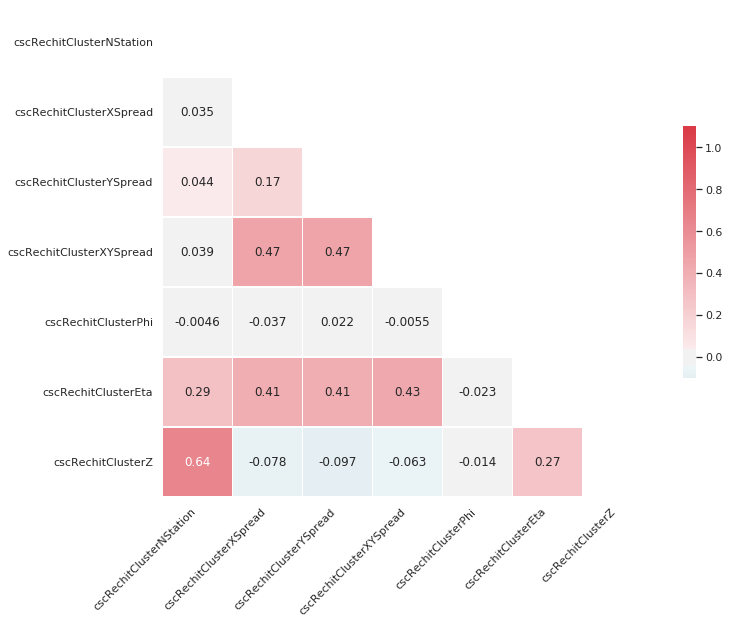

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")
corr = datasets['mc_signal'].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax=sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
f.tight_layout()
plt.show()

In [11]:
np.min(np.abs(cscRechitClusterZ['data']))

693.9447

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Error in <TH1D::DrawNormalized>: Sum of weights is null. Cannot normalize histogram: h


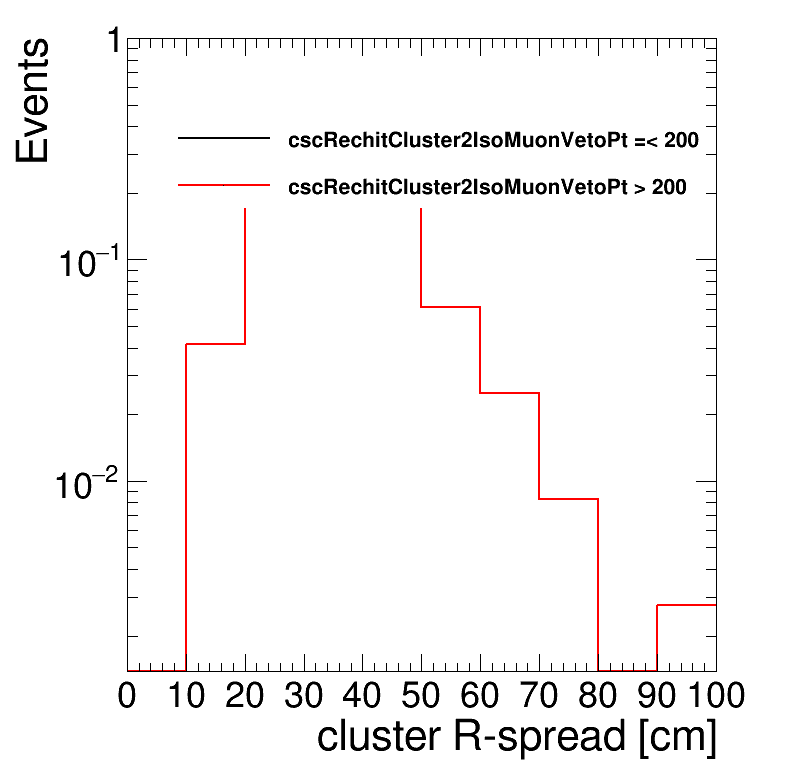

In [11]:

k = 'data'
var = [cscRechitClusterNStation, cscRechitClusterNStation5, cscRechitClusterNStation10perc, cscRechitClusterAvgStation, cscRechitClusterAvgStation5, cscRechitClusterAvgStation10perc,\
cscRechitClusterMaxStation, dphiMet_cluster, jetMet_dPhiMin, cscRechitClusterSize, bdt_score, cscRechitClusterEta, cscRechitClusterPhi, \
cscRechitClusterX, cscRechitClusterY, cscRechitClusterZ, cscRechitClusterR, \
   cscRechitClusterEtaSpread, cscRechitClusterPhiSpread, cscRechitClusterEtaPhiSpread, cscRechitClusterRSpread, cscRechitClusterXSpread, cscRechitClusterYSpread, cscRechitClusterZSpread, \
       cscRechitClusterTimeSpread, cscRechitClusterXYSpread, cscRechitCluster2IsoMuonVetoPt, cscRechitCluster2IsoMuonVetoE, cscRechitCluster2IsoMuonVetoEta]
title = ['N_{station}', 'N_{station}', 'N_{station}', 'Avg Station', 'Avg Station', 'Avg Station',\
    'max station', 'dphiMet_cluster', 'jetMet_dPhiMin','N_{rechits}', 'BDT score', 'cluster #eta', 'cluster #phi', \
         'cluster X [cm]','cluster Y [cm]','cluster Z [cm]', 'cluster R [cm]',\
         'cluster #eta spread', 'cluster #phi spread', 'cluster #eta-#phi spread', 'cluster R-spread [cm]', 'cluster X-spread [cm]','cluster Y-spread [cm]','cluster Z-spread [cm]',\
          'cluster time spread [ns]', 'cluster XY-spread [cm]', 'matched muon pT [GeV]', 'matched muon E [GeV]', 'matched muon #eta']

bins = [ [5,0,5], [5,0,5],[5,0,5],[30,1,4], [30,1,4],[30,1,4], \
        [5,0,5], [10,0,3.2], [10,0,3.2], [0, 50, 70, 100, 150, 250, 500], [10,0,1], [30,eta0,eta1+0.05],[25,0,3.2],\
        [15,0,700],[15,0,700], [50,650,1100], [50,200,800],\
        [25,0,0.2], [25,0,0.1],[25,0,0.1], [10,0,100], [20,0,100], [20,0,100], [20,0,100],
       [25,0,50],[20,0,60], [25,0,500], [25,0,500], [10,eta0-0.2,eta1+0.2],]

bins_ks = [ [5,0,5], [5,0,5],[5,0,5],[300,1,4], [300,1,4],[300,1,4], \
           [5,0,5], [1000,0,3.2], [1000,0,3.2], [0, 50, 70, 100, 150, 250, 500], [1000,0,1], [1000,eta0-0.2,eta1+0.2],[1000,0,3.2],\
           [1000,0,700],[1000,0,700], [1000,600,1100], [500,200,800],\
        [1000,0,0.2], [1000,0,0.1],[1000,0,0.05], [1000,0,150], [1000,0,150], [1000,0,150], [1000,0,200],
       [1000,0,50],[1000,0,60], [1000,0,600], [1000,0,600], [1000,eta0-0.3,eta1+0.3],]


names = ['cscRechitClusterNStation', 'cscRechitClusterNStation5', 'cscRechitClusterNStation10perc', 'cscRechitClusterAvgStation', 'cscRechitClusterAvgStation5', 'cscRechitClusterAvgStation10perc',\
         'cscRechitClusterMaxStation', 'dphiMet_cluster', 'jetMet_dPhiMin', 'cscRechitClusterSize', 'bdt_score', 'cscRechitClusterEta', 'cscRechitClusterPhi', \
         'cscRechitClusterX', 'cscRechitClusterY', 'cscRechitClusterZ', 'cscRechitClusterR',\
   'cscRechitClusterEtaSpread', 'cscRechitClusterPhiSpread', 'cscRechitClusterEtaPhiSpread', 'cscRechitClusterRSpread', 'cscRechitClusterXSpread', 'cscRechitClusterYSpread', 'cscRechitClusterZSpread', \
               'cscRechitClusterTimeSpread', 'cscRechitClusterXYSpread', 'cscRechitCluster2IsoMuonVetoPt', 'cscRechitCluster2IsoMuonVetoE', 'cscRechitCluster2IsoMuonVetoEta']
assert(len(var) == len(title) == len(names) == len(bins) == len(bins_ks))

for i in range(len(names)):
    if not i == 20: continue
    cond  = bdt_score[k]<=0.2
    cond = cscRechitCluster2IsoMuonVetoPt[k]<200
    h = {}
    leg = rt.TLegend(0.2,0.73,0.85,0.85)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)

    c = rt.TCanvas('c','c', 800, 800)
    rt.gStyle.SetOptFit(1011)
    # h = create_TH2D(np.column_stack((bdt_score[k][cond], var[i][k][cond])),  axis_title=['bdt score', title[i], 'Events'], binning = [10,0,1]+bins[i])
#     h = create_TH2D(np.column_stack((np.abs(cscRechitClusterEta[k][cond]), np.abs(cscRechitClusterPhi[k][cond]))),  axis_title=['eta', 'phi', 'Events'], binning = [50,0.9,1.2,50,0,3.2])

#     h = create_TH2D(np.column_stack((np.abs(cscRechitClusterXSpread[k][cond]), np.abs(cscRechitClusterYSpread[k][cond]))), \
#                     axis_title=['x spread', 'y spread', 'Events'], binning = [50,0,50,50,0,60])
#     h = create_TH2D(np.column_stack((np.abs(cscRechitClusterRSpread[k][cond]), (cscRechitClusterX[k][cond]**2+cscRechitClusterY[k][cond]**2)**0.5)), \
#                     axis_title=['r spread', 'r', 'Events'], binning = [50,0,100,50,500,700])




    h['low_bdt'] = create_TH1D(var[i][k][cond],  axis_title=[ title[i], 'Events'], binning = bins[i])
    h['high_bdt'] = create_TH1D(var[i][k][np.logical_not(cond)],  axis_title=[ title[i], 'Events'], binning = bins[i])

    h['low_bdt'].SetLineColor(1)
    h['high_bdt'].SetLineColor(2)
    leg.AddEntry(h['low_bdt'],'cscRechitCluster2IsoMuonVetoPt =< 200')
    leg.AddEntry(h['high_bdt'],'cscRechitCluster2IsoMuonVetoPt > 200')

    h['high_bdt'].SetMaximum(h['high_bdt'].Integral())


    h['high_bdt'].DrawNormalized()
    h['low_bdt'].DrawNormalized('same')
#     h.Draw('colz')
    c.SetRightMargin(0.1)
    c.SetLogy()
    leg.Draw()
    c.Draw()
#     c.SaveAs(dir_name+names[i]+"_withRatio_splitBDT_phi"+str(phi_corr).replace(".", "p")+"_r"+str(r_corr).replace(".", "p")+".png")






In [18]:
np.arange(0.8, 2.0, 0.2)

array([0.8, 1. , 1.2, 1.4, 1.6, 1.8])

# uncertainty calculation

In [34]:
%%time

import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
import os


pileupWeight = {}
weight = {}
cscRechitClusterXSpread = {}
cscRechitClusterYSpread = {}
cscRechitClusterEta = {}
cscRechitClusterPhi = {}
cscRechitClusterNStation5 = {}
cscRechitClusterAvgStation5 = {}
cscRechitClusterXYSpread = {}
cscRechitCluster2IsoMuonVetoE = {}
bdt_score = {}
datasets = {}
jetMet_dPhiMin = {}
dphiMet_cluster = {}
keys = ['mc_bkg', 'data', 'mc_bkg_corr']
unc = [] #data/mc_corr
unc2 = [] #mc/mc_corr
for eta0 in list(np.arange(0.8, 2.0, 0.2)):
    eta0 = round(eta0,2)
#     if not eta0 == 1.6: continue
    print("eta0", eta0)
    if eta0 == 0.8:
        phi_corr=0.75
        r_corr=1.2
    elif eta0 == 1.0:
        phi_corr=0.7
        r_corr=1.15
    elif eta0 == 1.2:
        phi_corr=0.6
        r_corr=1.1
    elif eta0 == 1.4:
        phi_corr=0.55
        r_corr=1.1
    elif eta0 == 1.6:
        phi_corr=0.75
        r_corr=1.1
    elif eta0 == 1.8:
        phi_corr=0.75
        r_corr=1.05
    else:
        print("ETA0 ERROR")

    for ind in range(len(phi_corr_lst)):
        if phi_corr_lst[ind] == phi_corr:phi_corr_i = ind
    for ind in range(len(r_corr_lst)):
        if r_corr_lst[ind] == r_corr:r_corr_i = ind
    
    for k in keys:
        if 'mc' in k: T = tree_bkg['mc']
        else: T = tree_bkg[k]
        sel_cluster = np.abs(T.array('cscRechitCluster2Time')) < 12.5
        sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2Size'))>=50)
        sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2TimeSpread'))<20)
        sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2MaxChamber')) > 12)            
        sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2Eta')) >= eta0)
        sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2Eta')) < eta0+1.2)    
        if k == 'mc_signal':
            sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitCluster2_match_gLLP') == 1)
            sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitCluster2_match_gLLP_csc') == 1)
        else:
            sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2IsoMuonVetoPt')) > 20)
            if 'mc_bkg' in k:
                sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitCluster2_match_gLLP') == 0) 
                sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitCluster2GenMuonVetoPt') > 20)
            elif k == 'data':
                if singleMuon:
                    sel_cluster = np.logical_and(sel_cluster, np.logical_or(T.array('cscRechitCluster2ZLep1') == 1, T.array('cscRechitCluster2ZLep2') == 1))
                else: 
                    sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2Met_dPhi')) < 2.5)
        # ########### BRANCHES ############
        sel_ev = sel_cluster.sum() >= 0 
        if k == 'data':
            if singleMuon: sel_ev = np.logical_and(sel_ev, T.array('category')==2)
            else: sel_ev = np.logical_and(sel_ev, np.abs(T.array('jetMet_dPhiMin'))>2)


#         print(k, "events", np.count_nonzero(sel_ev),  "cluster selection efficiency:", np.count_nonzero(sel_cluster.flatten())/len(sel_cluster.flatten()))

        cscRechitClusterXSpread[k] = T.array('cscRechitCluster2XSpread')[sel_cluster][sel_ev][:,0]
        cscRechitClusterYSpread[k] = T.array('cscRechitCluster2YSpread')[sel_cluster][sel_ev][:,0]
        cscRechitClusterXYSpread[k] = T.array('cscRechitCluster2XYSpread')[sel_cluster][sel_ev][:,0]
        cscRechitClusterEta[k] = T.array('cscRechitCluster2Eta')[sel_cluster][sel_ev][:,0]
        cscRechitClusterPhi[k] = T.array('cscRechitCluster2Phi')[sel_cluster][sel_ev][:,0]
        cscRechitClusterNStation5[k] = T.array('cscRechitCluster2NStation5')[sel_cluster][sel_ev][:,0]
        cscRechitClusterAvgStation5[k] = T.array('cscRechitCluster2AvgStation5')[sel_cluster][sel_ev][:,0]
        cscRechitCluster2IsoMuonVetoE[k] = T.array('cscRechitCluster2IsoMuonVetoE')[sel_cluster][sel_ev][:,0]
        dphiMet_cluster[k] = np.abs(T.array('cscRechitCluster2Met_dPhi'))[sel_cluster][sel_ev][:,0]
        if 'corr' in k:
            cscRechitClusterXSpread[k] = T.array('cscRechitCluster2XSpread_corr')[:,:,phi_corr_i,r_corr_i][sel_cluster][sel_ev][:,0]
            cscRechitClusterYSpread[k] = T.array('cscRechitCluster2YSpread_corr')[:,:,phi_corr_i,r_corr_i][sel_cluster][sel_ev][:,0]
            cscRechitClusterXYSpread[k] = T.array('cscRechitCluster2XYSpread_corr')[:,:,phi_corr_i,r_corr_i][sel_cluster][sel_ev][:,0]


        ##### bdt variables ####
        if bdt_name=='bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_XYspread_v11':
            bdt_var = {'cscRechitClusterNStation': cscRechitClusterNStation5[k],
            'cscRechitClusterXSpread': cscRechitClusterXSpread[k],
            'cscRechitClusterYSpread':cscRechitClusterYSpread[k],
            'cscRechitClusterXYSpread':cscRechitClusterXYSpread[k],
            'cscRechitClusterPhi':np.abs(cscRechitClusterPhi[k]),
            'cscRechitClusterEta':np.abs(cscRechitClusterEta[k]),
            'cscRechitClusterZ':np.abs(cscRechitClusterZ[k]),
            }
        elif bdt_name=='bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_XYspread_v12':
            bdt_var = {'cscRechitClusterNStation': cscRechitClusterNStation5[k],
            'cscRechitClusterXSpread': cscRechitClusterXSpread[k],
            'cscRechitClusterYSpread':cscRechitClusterYSpread[k],
            'cscRechitClusterXYSpread':cscRechitClusterXYSpread[k],
            'cscRechitClusterPhi':np.abs(cscRechitClusterPhi[k]),
            'cscRechitClusterEta':np.abs(cscRechitClusterEta[k]),
            'cscRechitClusterAvgStation5':np.abs(cscRechitClusterAvgStation5[k]),
            }
        else:
            print('BDT NOT FOUND')


        dataset = pd.DataFrame(bdt_var)
        assert(dataset.isnull().values.any() == False)
        datasets[k] = dataset
        bdt_score[k] = model.predict_proba(dataset.values)[:, 1] 
        jetMet_dPhiMin[k] = T.array('jetMet_dPhiMin')[sel_ev]


        weight[k] = T.array('weight')[sel_ev]*lumi
        pileupWeight[k] = T.array('pileupWeight')[sel_ev]
        if k == 'data':
            pileupWeight[k] = pileupWeight[k] * 0.0 + 1.0
            weight[k] = weight[k] * 0.0 + 1.0

    key_plot = ['data', 'mc_bkg_corr', 'mc_bkg']
    rt.gStyle.SetOptFit(1011)
    if singleMuon:
        dir_name = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/MCData_shape_comparison_SingleMuon_XYspread_'+bdt_name[-2:]+'_muonShower'+sig_ver+'_eta'+\
        str(eta0).replace(".", "p")+'to'+str(round(eta0+0.2,1)).replace(".", "p")+'/'
    else:
        
        dir_name = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/MCData_shape_comparison_MET_dphi2p5_XYspread_'+bdt_name[-2:]+'_muonShower'+sig_ver+'_eta'+\
        str(eta0).replace(".", "p")+'to'+str(round(eta0+0.2,1)).replace(".", "p")+'/'
    if not os.path.isdir(dir_name):os.makedirs(dir_name)

    h = {}
    below = {}
    above = {}   
    for i,k in enumerate(key_plot):
        total_weight = weight[k]
        ###########
        # reweight
        ##########
#         if 'mc_bkg' in k:
#             h_reweight = {}
#             h_reweight['mc_reweight'] = create_TH1D( np.abs(cscRechitCluster2IsoMuonVetoE[k]), axis_title=['cscRechitCluster2IsoMuonVetoE', 'Events'], name=k, binning=[25,0,500], weights = weight[k])
#             h_reweight['data_reweight'] = create_TH1D( np.abs(cscRechitCluster2IsoMuonVetoE['data']), axis_title=['cscRechitCluster2IsoMuonVetoE', 'Events'], name='data', binning=[25,0,500], weights = weight['data'])
#             h_reweight['data_reweight'].Divide(h_reweight['mc_reweight'])
#             reweight = []
#             for m in range(len(bdt_score[k])):
#                 reweight.append(h_reweight['data_reweight'].GetBinContent(h_reweight['data_reweight'].GetXaxis().FindFixBin(np.abs(cscRechitCluster2IsoMuonVetoE[k])[m])))
#             total_weight = total_weight * reweight
        h[k] = create_TH1D( np.abs(bdt_score[k]), axis_title=['bdt_score', 'Events'], name=k, binning=[10,0,1], weights = total_weight)
        h[k].SetLineColor(std_color_list[i])
        if k == 'mc_bkg': h[k].SetLineStyle(2)
        h[k].Scale(1./h[k].Integral())
        below[k] = 1.0*np.sum(total_weight[bdt_score[k]<bdt_cut])/np.sum(total_weight)
        above[k] = 1.0*np.sum(total_weight[bdt_score[k]>=bdt_cut])/np.sum(total_weight)
#         if k == 'mc_bkg_corr' and eta0 == 0.8:
#             print(total_weight[np.logical_and(bdt_score[k]<0.5, bdt_score[k]>0.4)])
#             print(weight[k][np.logical_and(bdt_score[k]<0.5, bdt_score[k]>0.4)])
#             print(cscRechitCluster2IsoMuonVetoE[k][np.logical_and(bdt_score[k]<0.5, bdt_score[k]>0.4)])
#             print(total_weight)
#         for binx in range(h[k].GetXaxis().GetNbins()+2):
#             print(k, binx, h[k].GetBinContent(binx))
#         if k == 'data':
#             print(jetMet_dPhiMin[k][bdt_score[k]<0.1])
#             print(dphiMet_cluster[k][bdt_score[k]<0.1])


    c = make_ratio_plot([h[key_plot[1]],h[key_plot[0]], h[key_plot[2]]], fit = False, logy=False, in_tags = ["MC corrected","Data", "MC uncorrected"], \
                        ratio_bounds = [0,3], draw_opt = ['E2','E1','hist'])   
    c.Draw()
#     c.SaveAs(dir_name+"bdt_score_uncorr_withRatio_cscRechitCluster2IsoMuonVetoEReweight_phi"+str(phi_corr).replace(".", "p")+"_r"+str(r_corr).replace(".", "p")+".png")
#     c.SaveAs(dir_name+"bdt_score_uncorr_withRatio_cscRechitCluster2IsoMuonVetoEReweight_phi"+str(phi_corr).replace(".", "p")+"_r"+str(r_corr).replace(".", "p")+".C")


#     print(above['data'], above['mc_bkg_corr'], above['mc_bkg'])
    unc.append(abs(above['data']/above['mc_bkg_corr']-1))
    unc2.append(abs(above['mc_bkg']/above['mc_bkg_corr']-1))


    print(eta0, phi_corr, r_corr, abs(above['data']/above['mc_bkg_corr']-1), abs(above['mc_bkg']/above['mc_bkg_corr']-1))





eta0 0.8


IndexError: index 0 is out of bounds for jagged min size 0

# uncertainty vs. eta

6 6 6


Info in <TCanvas::Print>: png file /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/MCData_shape_comparison_MET_dphi2p5_XYspread_12_muonShowerv15_eta1p8to2p0/uncertainty_vs_eta_MET.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/MCData_shape_comparison_MET_dphi2p5_XYspread_12_muonShowerv15_eta1p8to2p0/uncertainty_vs_eta_MET.C has been generated


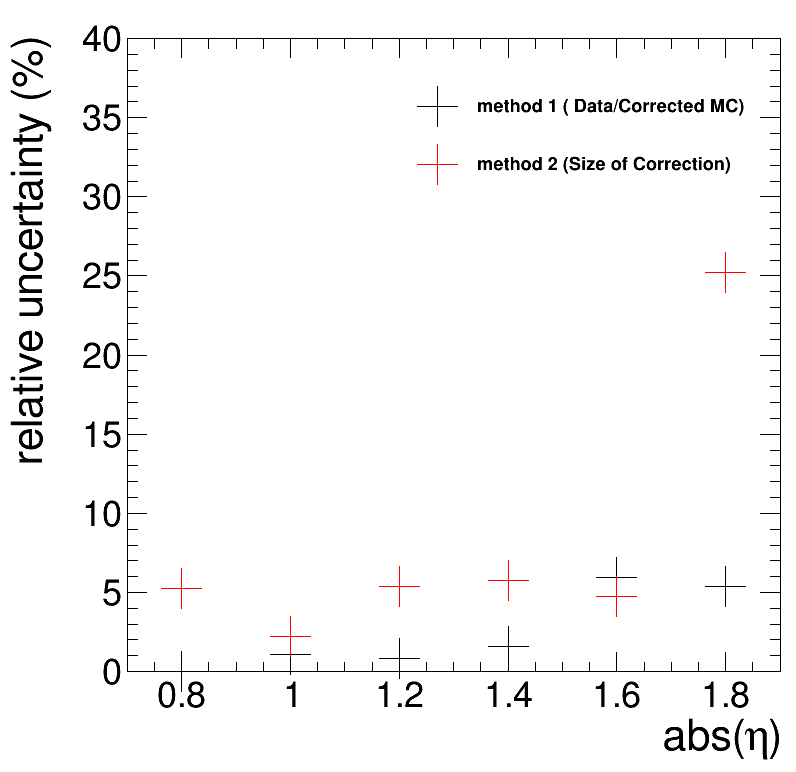

In [15]:
eta_list = list(np.arange(0.8, 2.0, 0.2))
unc = np.array(unc)
unc2 = np.array(unc2)

rt.gStyle.SetOptFit(1011)
leg = rt.TLegend(0.5,0.75,0.9,0.9)
leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)

h = {}

print(len(unc), len(unc2),len(eta_list))
h['method1'] = create_TGraph(eta_list, unc*100,  axis_title=['abs(#eta)', 'relative uncertainty (%)'])
h['method2'] = create_TGraph(eta_list, unc2*100,  axis_title=['abs(#eta)', 'relative uncertainty (%)'])


leg.AddEntry(h['method1'], "method 1 ( Data/Corrected MC)", 'P')
leg.AddEntry(h['method2'], "method 2 (Size of Correction)", 'P')

h['method2'].SetLineWidth(5)
h['method1'].SetLineWidth(5)
h['method1'].SetMarkerColor(std_color_list[0])
h['method2'].SetMarkerColor(std_color_list[1])
h['method1'].SetMarkerStyle(std_color_list[1])
h['method2'].SetMarkerStyle(std_color_list[1])
h['method1'].SetMarkerSize(5)
h['method2'].SetMarkerSize(5)
h['method1'].GetYaxis().SetRangeUser(0,40)



h['method1'].Draw('AP')
h['method2'].Draw("P")

# h[m].SetLineWidth(3)
# h[m].GetXaxis().SetLimits(0.01,1000.0)
# h[m].GetYaxis().SetRangeUser(1e-4,100)
# h[m].GetXaxis().SetTitleOffset(1)

# tdrstyle.setTDRStyle()
# CMS_lumi.cmsText     = "CMS"
# iPos = 0
# CMS_lumi.writeExtraText = True
# CMS_lumi.extraText   = "Preliminary"


leg.Draw()
# c.SetRightMargin(0.03)

# c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/'+bdt_name+'/'+decay+'.png')
# c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/'+bdt_name+'/'+decay+'.C')
if singleMuon: file_name = "uncertainty_vs_eta_singleMuon"
else: file_name = "uncertainty_vs_eta_MET"
c.SaveAs(dir_name + file_name + ".png")
c.SaveAs(dir_name + file_name + ".C")





c.Draw()


# with ratio plot

29 29 29 29
1.0
0.9999999999999999
1.0
ZMass 8.86577584260858e-20


Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: mc_bkg (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: mc_signal (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio


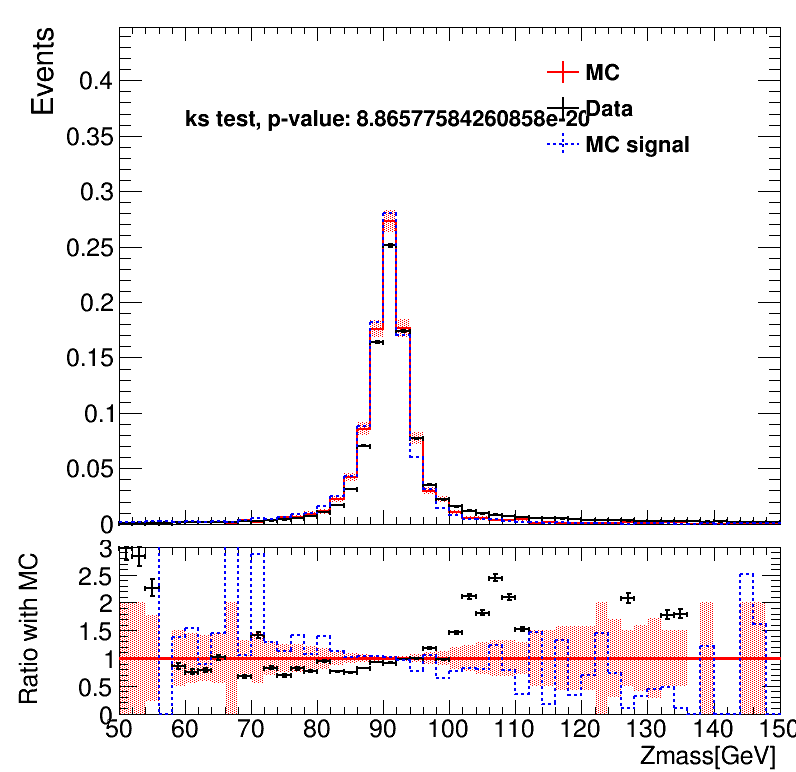

In [44]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
import os

# Plotting ncsc
start_t = time.time()
reweight_flag =0
logy = 0
ks_prob = []


if r_corr_flag: ks_prob_str = "phi"+str(phi_corr).replace(".", "p")+"_r"+str(r_corr).replace(".", "p")+'\t'
else: ks_prob_str = "phi"+str(phi_corr).replace(".", "p")+'\t'




rt.gStyle.SetOptFit(1011)


var = [ZMass, cscRechitClusterNStation, cscRechitClusterNStation5, cscRechitClusterNStation10perc, cscRechitClusterAvgStation, cscRechitClusterAvgStation5, cscRechitClusterAvgStation10perc,\
    cscRechitClusterMaxStation, dphiMet_cluster, jetMet_dPhiMin, cscRechitClusterSize, bdt_score, cscRechitClusterEta, cscRechitClusterPhi, \
       cscRechitClusterX, cscRechitClusterY, cscRechitClusterZ, \
           cscRechitClusterEtaSpread, cscRechitClusterPhiSpread, cscRechitClusterEtaPhiSpread, cscRechitClusterRSpread, cscRechitClusterXSpread, cscRechitClusterYSpread, cscRechitClusterZSpread, \
               cscRechitClusterTimeSpread, cscRechitClusterXYSpread, cscRechitCluster2IsoMuonVetoPt, cscRechitCluster2IsoMuonVetoE, cscRechitCluster2IsoMuonVetoEta]
title = ['Zmass[GeV]', 'N_{station}', 'N_{station}', 'N_{station}', 'Avg Station', 'Avg Station', 'Avg Station',\
    'max station', 'dphiMet_cluster', 'jetMet_dPhiMin','N_{rechits}', 'BDT score', 'cluster #eta', 'cluster #phi', 'cluster X [cm]','cluster Y [cm]','cluster Z [cm]', \
         'cluster #eta spread', 'cluster #phi spread', 'cluster #eta-#phi spread', 'cluster R-spread [cm]', 'cluster X-spread [cm]','cluster Y-spread [cm]','cluster Z-spread [cm]',\
          'cluster time spread [ns]', 'cluster XY-spread [cm]', 'matched muon pT [GeV]', 'matched muon E [GeV]', 'matched muon #eta']

bins = [ [50,50,150],[30,1,4], [30,1,4],[30,1,4],[30,1,4], [30,1,4],[30,1,4], \
        [30,1,4], [10,0,3.2], [10,0,3.2], [0, 50, 70, 100, 150, 250, 500], [10,0,1], [30,eta0,eta1+0.05],[25,0,3.2],\
        [15,0,700],[15,0,700], [50,690,710], 
        [25,0,0.2], [12,0,0.1],[25,0,0.1], [10,0,100], [20,0,100], [20,0,100], [20,0,100],
       [25,0,50],[20,0,60], [25,0,500], [50,0,2000], [10,eta0-0.2,eta1+0.2],]

bins_ks = [[500,0,200],[300,1,4], [300,1,4],[300,1,4],[300,1,4], [10,1,4],[300,1,4], \
           [300,1,4], [1000,0,3.2], [1000,0,3.2], [0, 50, 70, 100, 150, 250, 500], [1000,0,1], [1000,eta0-0.2,eta1+0.2],[1000,0,3.2],\
           [1000,0,700],[1000,0,700], [1000,600,1100], 
        [1000,0,0.2], [1000,0,0.1],[1000,0,0.05], [1000,0,150], [1000,0,150], [1000,0,150], [1000,0,200],
       [1000,0,50],[1000,0,60], [1000,0,600], [1000,0,600], [1000,eta0-0.3,eta1+0.3],]


names = ['ZMass', 'cscRechitClusterNStation', 'cscRechitClusterNStation5', 'cscRechitClusterNStation10perc', 'cscRechitClusterAvgStation', 'cscRechitClusterAvgStation5', 'cscRechitClusterAvgStation10perc',\
         'cscRechitClusterMaxStation', 'dphiMet_cluster', 'jetMet_dPhiMin', 'cscRechitClusterSize', 'bdt_score', 'cscRechitClusterEta', 'cscRechitClusterPhi', \
         'cscRechitClusterX', 'cscRechitClusterY', 'cscRechitClusterZ', \
   'cscRechitClusterEtaSpread', 'cscRechitClusterPhiSpread', 'cscRechitClusterEtaPhiSpread', 'cscRechitClusterRSpread', 'cscRechitClusterXSpread', 'cscRechitClusterYSpread', 'cscRechitClusterZSpread', \
               'cscRechitClusterTimeSpread', 'cscRechitClusterXYSpread', 'cscRechitCluster2IsoMuonVetoPt', 'cscRechitCluster2IsoMuonVetoE', 'cscRechitCluster2IsoMuonVetoEta']
assert(len(var) == len(title) == len(names) == len(bins) == len(bins_ks))


key_plot = ['data', 'mc_bkg', 'mc_signal']

assert(len(var) == len(title) == len(names) == len(bins))
print(len(var), len(title), len(names), len(bins))
for j,v in enumerate(var):
    if not j == 0:continue
    leg = rt.TLegend(0.55,0.80,0.87,0.90)

    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    c = rt.TCanvas('c','c', 800, 800)

    h = {}
    h_ks = {}
    maximum = 0
    for i,k in enumerate(key_plot):
        total_weight = pileupWeight[k]* weight[k]


        ###########
        # reweight
        ##########
        if k == 'mc_bkg' and reweight_flag:
            h_reweight = {}
            reweight_index = 26
#             print("reweight",names[reweight_index], "plot", names[j])
            h_reweight['mc_reweight'] = create_TH1D( np.abs(var[reweight_index][k]), axis_title=[title[reweight_index], 'Events'], name=k, binning=bins[reweight_index], weights = pileupWeight[k]* weight[k])
            h_reweight['data_reweight'] = create_TH1D( np.abs(var[reweight_index]['data']), axis_title=[title[reweight_index], 'Events'], name=k, binning=bins[reweight_index], weights = pileupWeight['data']* weight['data'])
            h_reweight['data_reweight'].Divide(h_reweight['mc_reweight'])
            reweight = []
            for m in range(len(v[k])):
                reweight.append(h_reweight['data_reweight'].GetBinContent(h_reweight['data_reweight'].GetXaxis().FindFixBin(np.abs(var[reweight_index][k])[m])))
            total_weight = total_weight * reweight
#         cond = np.logical_and(np.abs(cscRechitClusterEta[k])<2, np.abs(cscRechitClusterEta[k])>1)
        cond = cscRechitClusterNStation[k]>=1
#         cond = np.logical_and(cond, np.abs(cscRechitClusterZ[k])>780)
#         cond = np.logical_and(cond, np.abs(cscRechitClusterZ[k])<860)


        h[k] = create_TH1D( np.abs(v[k][cond]), axis_title=[title[j], 'Events'], name=k, binning=bins[j], weights = total_weight[cond])
        h_ks[k] = create_TH1D( np.abs(v[k]), axis_title=[title[j], 'Events'], name=k, binning=bins_ks[j], weights = total_weight)
        h[k].SetLineColor(std_color_list[i])
        maximum = max(maximum, h[k].GetMaximum())
        if logy: h[k].SetMaximum(maximum*10)
        else: h[k].SetMaximum(maximum*10)
    #     h[str(i)].SetMinimum(0.1)
        if 'signal' in k: h[k].SetLineStyle(2)
        h[k].GetXaxis().SetLabelSize(0.04)
#         h[k].DrawNormalized('same hist')
#         if names[j] == 'bdt_score': print('bdt efficiency', k, np.count_nonzero(v[k]>bdt_cut)/len(v[k]))
        h[k].Scale(1./h[k].Integral())
        print(h[k].Integral())
    texts = 'ks test, p-value: ' + str(h_ks['data'].KolmogorovTest(h_ks['mc_bkg']))

    c = make_ratio_plot([h[key_plot[1]],h[key_plot[0]], h[key_plot[2]]], fit = False, logy=0, in_tags = ["MC","Data", "MC signal"], ratio_bounds = [0,3], \
                        draw_opt = ['E2','E1','hist'], text = texts)


    c.SetRightMargin(0.2)
    if logy: c.SetLogy()
    print(names[j], h_ks['data'].KolmogorovTest(h_ks['mc_bkg']))
    ks_prob.append(h_ks['data'].KolmogorovTest(h_ks['mc_bkg']))
    ks_prob_str += str(h_ks['data'].KolmogorovTest(h_ks['mc_bkg'])) + '\t'
    c.Draw()
    
#     if reweight_flag:
#         if r_corr_flag: c.SaveAs(dir_name+names[j]+"_withRatio_"+names[reweight_index]+"Reweight_phi"+phi_corr+"_r"+r_corr+".png")
#         else: c.SaveAs(dir_name+names[j]+"_withRatio_"+names[reweight_index]+"Reweight_phi"+phi_corr+".png")
        
#     else:
#         if r_corr_flag:  c.SaveAs(dir_name+names[j]+"_withRatio_phi"+phi_corr+"_r"+r_corr+".png")
#         else:c.SaveAs(dir_name+names[j]+"_withRatio_phi"+phi_corr+".png")
#         text_name = dir_name+"corrections.txt"


# write the p-value to the text file for each correction
# if reweight_flag:text_name = dir_name+"corrections_"+names[reweight_index]+"_reweight.txt"
# else: text_name = dir_name+"corrections.txt"
# if not os.path.isfile(text_name):
#     text_file = open(text_name, "w")
#     title = "Corrections \t"
#     for n in names: title = title+n+'\t'
#     text_file.write(title+'\n')
#     print("new text file created")
# else:
#     text_file = open(text_name, "a+")
#     print("appending to existing file")


# text_file.write(ks_prob_str+'\n')
# text_file.close()







# KS test

In [ ]:
#fine tune correction

In [ ]:
%%time

start_t = time.time()
jetPt_cut = 50
tightid = False
pileupWeight = {}
weight = {}
npv = {}
npu = {}
nJets = {}
nJets_50gev = {}
jetPt = {}
jetPhi = {}
jetEta = {}
metPhi = {}
met = {}
jetMet_dPhiMin4 = {}
nJets = {}
jetPhi = {}
jetPt = {}
cscRechitClusterJetPhi = {}
cscRechitClusterXSpread = {}
cscRechitClusterYSpread = {}
cscRechitClusterZSpread = {}
cscRechitClusterEtaSpread = {}
cscRechitClusterPhiSpread = {}
cscRechitClusterEtaPhiSpread = {}
dphiMet_cluster = {}
cscRechitClusterX = {}
cscRechitClusterY = {}
cscRechitClusterZ = {}
cscRechitClusterEta = {}
cscRechitClusterPhi = {}
cscRechitClusterNStation = {}
cscRechitClusterXYSpread = {}
cscRechitClusterRSpread = {}
cscRechitClusterSize = {}
cscRechitCluster2JetVetoPt = {}
cscRechitCluster2IsoMuonVetoPt = {}
cscRechitCluster2IsoMuonVetoE = {}
cscRechitCluster2IsoMuonVetoEta = {}
cscRechitClusterTimeSpread = {}
jetMet_dPhiMin = {}
bdt_score = {}

keys = ['mc_bkg', 'mc_signal', 'data']
phi_corr = '0p7'
r_corr = '1p2'
eta0 = 1.0
eta1 = eta0 + 0.2
for phi_corr in ['0p5', '0p55', '0p6', '0p65', '0p7', '0p75']:
    r_corr_flag = 0
    for r_corr in ['1p1', '1p15', '1p2', '1p25', '1p3']:
        if phi_corr == '0p7': r_corr_flag = 1
        elif (not phi_corr == '0p7' and not r_corr == '1p1'): continue;
        print(phi_corr, r_corr, r_corr_flag)
        for k in keys:
            if 'mc' in k: T = tree_bkg['mc']
            else: T = tree_bkg[k]

            sel_cluster = np.abs(T.array('cscRechitCluster2Time')) < 12.5
            sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2TimeSpread'))<20)
            sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2MaxChamber')) > 12)
        #     me1112_veto = 0
        #     sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitCluster2NRechitChamberPlus11') <= me1112_veto)
        #     sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitCluster2NRechitChamberPlus12') <= me1112_veto)
        #     sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitCluster2NRechitChamberMinus11') <= me1112_veto)
        #     sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitCluster2NRechitChamberMinus12') <= me1112_veto)

            sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2Eta')) >= eta0)
            sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2Eta')) < eta1)    
            if k == 'mc_signal':
                sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitCluster2_match_gLLP') == 1)
                sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitCluster2_match_gLLP_csc') == 1)
            else:
                sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2IsoMuonVetoPt')) > 20)
                if k == 'mc_bkg':
                    sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitCluster2_match_gLLP') == 0)
                    sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitCluster2GenMuonVetoPt') > 20)
                elif k == 'data':
        #             sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2Met_dPhi')) < 1)
                    sel_cluster = np.logical_and(sel_cluster, np.logical_or(np.abs(T.array('cscRechitCluster2ZLep1')) == 1, np.abs(T.array('cscRechitCluster2ZLep2')) == 1))




            print(k, "cluster selection efficiency:", np.count_nonzero(sel_cluster.flatten())/len(sel_cluster.flatten()))


        # ########### BRANCHES ############
            sel_ev = sel_cluster.sum() ==1 
            if k == 'data':
        #         sel_ev = np.logical_and(sel_ev, np.abs(T.array('jetMet_dPhiMin'))>2.5)
                sel_ev = np.logical_and(sel_ev, T.array('category')==2)
            print(k, np.count_nonzero(sel_ev))
        #     if k == 'data': sel_ev = np.logical_and(sel_ev, T.array('jetMet_dPhiMin')>1)

        #     if k == 'data': sel_ev = np.logical_and(sel_ev, cscRechitClusterJetPhi[k]>1)


        #     if 'mc' in k:
        #         gLLP_decay_vertex_z = T.array('gLLP_decay_vertex_z')
        #         gLLP_decay_vertex_r = T.array('gLLP_decay_vertex_r')


        #         distance0 = np.sqrt(gLLP_decay_vertex_z[:,0]**2+gLLP_decay_vertex_r[:,0]**2)
        #         distance1 = np.sqrt(gLLP_decay_vertex_z[:,1]**2+gLLP_decay_vertex_r[:,1]**2)
        #         cond1 = np.logical_or(distance1<200, np.logical_or(gLLP_decay_vertex_z[:,1]>1100, gLLP_decay_vertex_r[:,1]>800))
        #         cond0 = np.logical_or(distance0<200, np.logical_or(gLLP_decay_vertex_z[:,0]>1100, gLLP_decay_vertex_r[:,0]>800))
        #         sel_ev = np.logical_and(sel_ev, np.logical_and(cond0, cond1))
            print(np.count_nonzero(sel_ev))
            cscRechitClusterXSpread[k] = T.array('cscRechitCluster2XSpread')[sel_cluster][sel_ev][:,0]
            cscRechitClusterYSpread[k] = T.array('cscRechitCluster2YSpread')[sel_cluster][sel_ev][:,0]
            cscRechitClusterZSpread[k] = T.array('cscRechitCluster2ZSpread')[sel_cluster][sel_ev][:,0]
            cscRechitClusterEtaSpread[k] = T.array('cscRechitCluster2EtaSpread')[sel_cluster][sel_ev][:,0]
            cscRechitClusterPhiSpread[k] = T.array('cscRechitCluster2PhiSpread')[sel_cluster][sel_ev][:,0]
            cscRechitClusterXYSpread[k] = T.array('cscRechitCluster2XYSpread')[sel_cluster][sel_ev][:,0]
            cscRechitClusterRSpread[k] = T.array('cscRechitCluster2RSpread')[sel_cluster][sel_ev][:,0]
            cscRechitClusterNStation[k] = T.array('cscRechitCluster2NStation')[sel_cluster][sel_ev][:,0]
            cscRechitClusterEtaPhiSpread[k] = T.array('cscRechitCluster2EtaPhiSpread')[sel_cluster][sel_ev][:,0]


            if 'mc' in k:
                if r_corr_flag:
                    cscRechitClusterXSpread[k] = T.array('cscRechitCluster2XSpread_phi'+phi_corr+'_r'+r_corr)[sel_cluster][sel_ev][:,0]
                    cscRechitClusterYSpread[k] = T.array('cscRechitCluster2YSpread_phi'+phi_corr+'_r'+r_corr)[sel_cluster][sel_ev][:,0]
                    cscRechitClusterXYSpread[k] = T.array('cscRechitCluster2XYSpread_phi'+phi_corr+'_r'+r_corr)[sel_cluster][sel_ev][:,0]
                    cscRechitClusterEtaPhiSpread[k] = T.array('cscRechitCluster2EtaPhiSpread_phi'+phi_corr+'_r'+r_corr)[sel_cluster][sel_ev][:,0]
                    cscRechitClusterEtaSpread[k] = T.array('cscRechitCluster2EtaSpread_phi'+phi_corr+'_r'+r_corr)[sel_cluster][sel_ev][:,0]
                    cscRechitClusterPhiSpread[k] = T.array('cscRechitCluster2PhiSpread_phi'+phi_corr+'_r'+r_corr)[sel_cluster][sel_ev][:,0]
                    cscRechitClusterRSpread[k] = T.array('cscRechitCluster2RSpread_phi'+phi_corr+'_r'+r_corr)[sel_cluster][sel_ev][:,0]
                else:
                    cscRechitClusterXSpread[k] = T.array('cscRechitCluster2XSpread_phi'+phi_corr)[sel_cluster][sel_ev][:,0]
                    cscRechitClusterYSpread[k] = T.array('cscRechitCluster2YSpread_phi'+phi_corr)[sel_cluster][sel_ev][:,0]
                    cscRechitClusterXYSpread[k] = T.array('cscRechitCluster2XYSpread_phi'+phi_corr)[sel_cluster][sel_ev][:,0]
                    cscRechitClusterEtaPhiSpread[k] = T.array('cscRechitCluster2EtaPhiSpread_phi'+phi_corr)[sel_cluster][sel_ev][:,0]
                    cscRechitClusterPhiSpread[k] = T.array('cscRechitCluster2PhiSpread_phi'+phi_corr)[sel_cluster][sel_ev][:,0]

            cscRechitClusterX[k] = T.array('cscRechitCluster2X')[sel_cluster][sel_ev][:,0]
            cscRechitClusterY[k] = T.array('cscRechitCluster2Y')[sel_cluster][sel_ev][:,0]
            cscRechitClusterZ[k] = T.array('cscRechitCluster2Z')[sel_cluster][sel_ev][:,0]
            cscRechitClusterEta[k] = T.array('cscRechitCluster2Eta')[sel_cluster][sel_ev][:,0]
            cscRechitClusterPhi[k] = T.array('cscRechitCluster2Phi')[sel_cluster][sel_ev][:,0]
            cscRechitClusterSize[k] = T.array('cscRechitCluster2Size')[sel_cluster][sel_ev][:,0]
            cscRechitClusterTimeSpread[k] = T.array('cscRechitCluster2TimeSpread')[sel_cluster][sel_ev][:,0]

            cscRechitCluster2IsoMuonVetoPt[k] = T.array('cscRechitCluster2IsoMuonVetoPt')[sel_cluster][sel_ev][:,0]
            cscRechitCluster2IsoMuonVetoE[k] = T.array('cscRechitCluster2IsoMuonVetoE')[sel_cluster][sel_ev][:,0]
            cscRechitCluster2IsoMuonVetoEta[k] = T.array('cscRechitCluster2IsoMuonVetoEta')[sel_cluster][sel_ev][:,0]
            dphiMet_cluster[k] = np.abs(T.array('cscRechitCluster2Met_dPhi'))[sel_cluster][sel_ev][:,0]
            cscRechitCluster2JetVetoPt[k] = T.array('cscRechitCluster2JetVetoPt')[sel_cluster][sel_ev][:,0]




           ##### cluster-level variables ##### 
        #     if bdt_model == 0:

        #         bdt_var = {'cscRechitClusterXSpread': cscRechitClusterXSpread[k],
        #          'cscRechitClusterYSpread': cscRechitClusterYSpread[k],
        #          'cscRechitClusterNStation':cscRechitClusterNStation[k],
        #          'cscRechitClusterEtaPhiSpread':cscRechitClusterEtaPhiSpread[k],
        #          'cscRechitClusterX':cscRechitClusterX[k],
        #          'cscRechitClusterY':cscRechitClusterY[k],
        #          'cscRechitClusterZ':cscRechitClusterZ[k],
        #         }
        #     elif bdt_model == 1:
        #         bdt_var = {'cscRechitClusterXSpread': cscRechitClusterXSpread[k],
        #          'cscRechitClusterYSpread': cscRechitClusterYSpread[k],
        #          'cscRechitClusterNStation':cscRechitClusterNStation[k],
        #          'cscRechitClusterEtaPhiSpread':cscRechitClusterEtaPhiSpread[k],
        #          'cscRechitClusterX':np.abs(cscRechitClusterX[k]),
        #          'cscRechitClusterY':np.abs(cscRechitClusterY[k]),
        #          'cscRechitClusterZ':np.abs(cscRechitClusterZ[k]),
        #         }
            if 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_XYspread' in bdt_name:
                bdt_var = {'cscRechitClusterNStation': cscRechitClusterNStation[k],
                'cscRechitClusterXSpread': cscRechitClusterXSpread[k],
                'cscRechitClusterYSpread':cscRechitClusterYSpread[k],
                'cscRechitClusterXYSpread':cscRechitClusterXYSpread[k],
                'cscRechitClusterPhi':np.abs(cscRechitClusterPhi[k]),
                'cscRechitClusterEta':np.abs(cscRechitClusterEta[k]),
                'cscRechitClusterZ':np.abs(cscRechitClusterZ[k]),
                }
            else:
                print('BDT NOT FOUND')


        ##### bdt variables ####
            dataset = pd.DataFrame(bdt_var)
            bdt_score[k] = model.predict_proba(dataset.values)[:, 1]


            met[k] = T.array('met') [sel_ev]
            metPhi[k] = T.array('metPhi')[sel_ev]
            npv[k] = T.array('npv')[sel_ev]
            weight[k] = T.array('weight')[sel_ev]*lumi
            pileupWeight[k] = T.array('pileupWeight')[sel_ev]
            jetMet_dPhiMin[k] = T.array('jetMet_dPhiMin')[sel_ev]
            nJets[k] = T.array('nJets')[sel_ev]
            jetPhi[k] = T.array('jetPhi')[sel_ev]
            jetPt[k] = T.array('jetPt')[sel_ev]

        #     cscRechitClusterJetPhi[k] = []
        #     for ev in range(len(nJets[k])):
        #         temp_max = 99;
        #         for jPhi in jetPhi[k][ev]:
        #             temp_max = min(abs(deltaPhi(jPhi, cscRechitClusterPhi[k][ev])), temp_max)
        #         cscRechitClusterJetPhi[k].append(temp_max)
        #     cscRechitClusterJetPhi[k] = np.array(cscRechitClusterJetPhi[k])

            if k == 'data':
                pileupWeight[k] = pileupWeight[k] * 0.0 + 1.0
                weight[k] = weight[k] * 0.0 + 1.0
        #         print(cscRechitClusterXSpread[k][bdt_score[k]<0.1])
        #         print(cscRechitClusterYSpread[k][bdt_score[k]<0.1])
        #         print(cscRechitClusterXYSpread[k][bdt_score[k]<0.1])
        #         print(cscRechitClusterPhi[k][bdt_score[k]<0.1])
        #         print(cscRechitClusterEta[k][bdt_score[k]<0.1])
        import importlib
        importlib.reload(sys.modules['histo_utilities'])
        from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
        import os

        # Plotting ncsc
        start_t = time.time()
        reweight_flag =1
        logy = 0
        ks_prob = []



        if r_corr_flag: ks_prob_str = "phi"+phi_corr+"_r"+r_corr+'\t'
        else: ks_prob_str = "phi"+phi_corr+'\t'



        rt.gStyle.SetOptFit(1011)
        dir_name = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/MCData_shape_comparison_SingleMuon_XYspread_'+bdt_name[-2:]+'_muonShower_eta'+\
        str(eta0).replace(".", "p")+'to'+str(eta1).replace(".", "p")+'/'


        if not os.path.isdir(dir_name):os.makedirs(dir_name)
        var = [dphiMet_cluster, jetMet_dPhiMin, cscRechitClusterSize, bdt_score, cscRechitClusterEta, cscRechitClusterPhi, cscRechitClusterX, cscRechitClusterY, cscRechitClusterZ, \
           cscRechitClusterEtaSpread, cscRechitClusterPhiSpread, cscRechitClusterEtaPhiSpread, cscRechitClusterRSpread, cscRechitClusterXSpread, cscRechitClusterYSpread, cscRechitClusterZSpread, \
               cscRechitClusterTimeSpread, cscRechitClusterXYSpread, cscRechitClusterNStation, cscRechitCluster2IsoMuonVetoPt, cscRechitCluster2IsoMuonVetoE, cscRechitCluster2IsoMuonVetoEta]
        title = ['dphiMet_cluster', 'jetMet_dPhiMin','N_{rechits}', 'BDT score', 'cluster #eta', 'cluster #phi', 'cluster X [cm]','cluster Y [cm]','cluster Z [cm]', \
                 'cluster #eta spread', 'cluster #phi spread', 'cluster #eta-#phi spread', 'cluster R-spread [cm]', 'cluster X-spread [cm]','cluster Y-spread [cm]','cluster Z-spread [cm]',\
                  'cluster time spread [ns]', 'cluster XY-spread [cm]','N_{station}', 'matched muon pT [GeV]', 'matched muon E [GeV]', 'matched muon #eta']

        bins = [[10,0,3.2], [10,0,3.2], [0, 50, 70, 100, 150, 250, 500], [10,0,1], [10,eta0-0.2,eta1+0.2],[10,0,3.2],[15,0,700],[15,0,700], [25,600,1100], 
                [25,0,0.2], [25,0,0.1],[25,0,0.1], [10,0,100], [20,0,100], [20,0,100], [20,0,100],
               [25,0,50],[20,0,60],[5,0,5], [10,0,500], [10,0,500], [10,eta0-0.2,eta1+0.2],]

        bins_ks = [[1000,0,3.2], [1000,0,3.2], [0, 50, 70, 100, 150, 250, 500], [1000,0,1], [1000,eta0-0.2,eta1+0.2],[1000,0,3.2],[1000,0,700],[1000,0,700], [1000,600,1100], 
                [1000,0,0.2], [1000,0,0.1],[1000,0,0.05], [1000,0,150], [1000,0,150], [1000,0,150], [1000,0,200],
               [1000,0,50],[1000,0,60],[1000,0,5], [1000,0,600], [1000,0,600], [1000,eta0-0.3,eta1+0.3],]


        names = ['dphiMet_cluster', 'jetMet_dPhiMin', 'cscRechitClusterSize', 'bdt_score', 'cscRechitClusterEta', 'cscRechitClusterPhi', 'cscRechitClusterX', 'cscRechitClusterY', 'cscRechitClusterZ', \
           'cscRechitClusterEtaSpread', 'cscRechitClusterPhiSpread', 'cscRechitClusterEtaPhiSpread', 'cscRechitClusterRSpread', 'cscRechitClusterXSpread', 'cscRechitClusterYSpread', 'cscRechitClusterZSpread', \
               'cscRechitClusterTimeSpread', 'cscRechitClusterXYSpread', 'cscRechitClusterNStation', 'cscRechitCluster2IsoMuonVetoPt', 'cscRechitCluster2IsoMuonVetoE', 'cscRechitCluster2IsoMuonVetoEta']
        key_plot = ['data', 'mc_bkg', 'mc_signal']

        assert(len(var) == len(title) == len(names) == len(bins))
        print(len(var), len(title), len(names), len(bins))
        for j,v in enumerate(var):
        #     if not j == 21:continue
            leg = rt.TLegend(0.55,0.80,0.87,0.90)

            leg.SetTextSize(0.03)
            leg.SetBorderSize(0)
            leg.SetEntrySeparation(0.01)
            c = rt.TCanvas('c','c', 800, 800)

            h = {}
            h_ks = {}
            maximum = 0
            for i,k in enumerate(key_plot):
                total_weight = pileupWeight[k]* weight[k]


                ###########
                # reweight
                ##########
                if k == 'mc_bkg' and reweight_flag:
                    h_reweight = {}
                    reweight_index = 20
        #             print("reweight",names[reweight_index], "plot", names[j])
                    h_reweight['mc_reweight'] = create_TH1D( np.abs(var[reweight_index][k]), axis_title=[title[reweight_index], 'Events'], name=k, binning=bins[reweight_index], weights = pileupWeight[k]* weight[k])
                    h_reweight['data_reweight'] = create_TH1D( np.abs(var[reweight_index]['data']), axis_title=[title[reweight_index], 'Events'], name=k, binning=bins[reweight_index], weights = pileupWeight['data']* weight['data'])
                    h_reweight['data_reweight'].Divide(h_reweight['mc_reweight'])
                    reweight = []
                    for m in range(len(v[k])):
                        reweight.append(h_reweight['data_reweight'].GetBinContent(h_reweight['data_reweight'].GetXaxis().FindFixBin(np.abs(var[reweight_index][k])[m])))
                    total_weight = total_weight * reweight

                h[k] = create_TH1D( np.abs(v[k]), axis_title=[title[j], 'Events'], name=k, binning=bins[j], weights = total_weight)
                h_ks[k] = create_TH1D( np.abs(v[k]), axis_title=[title[j], 'Events'], name=k, binning=bins_ks[j], weights = total_weight)

                h[k].SetLineColor(std_color_list[i])
                maximum = max(maximum, h[k].GetMaximum())
                if logy: h[k].SetMaximum(maximum*10)
                else: h[k].SetMaximum(maximum*10)
            #     h[str(i)].SetMinimum(0.1)
                if 'signal' in k: h[k].SetLineStyle(2)
                h[k].GetXaxis().SetLabelSize(0.04)
        #         h[k].DrawNormalized('same hist')
        #         if names[j] == 'bdt_score': print('bdt efficiency', k, np.count_nonzero(v[k]>bdt_cut)/len(v[k]))
                h[k].Scale(1./h[k].Integral())
            c = make_ratio_plot([h[key_plot[1]],h[key_plot[0]], h[key_plot[2]]], fit = False, logy=logy, in_tags = ["MC","Data", "MC signal"], ratio_bounds = [0,3], draw_opt = ['E2','E1','hist'])
            c.SetRightMargin(0.2)
            if logy: c.SetLogy()
            print(names[j], h_ks['data'].KolmogorovTest(h_ks['mc_bkg']))
            ks_prob.append(h_ks['data'].KolmogorovTest(h_ks['mc_bkg']))
            ks_prob_str += str(h_ks['data'].KolmogorovTest(h_ks['mc_bkg'])) + '\t'
            c.Draw()

        #     if reweight_flag:
        #         if r_corr_flag: c.SaveAs(dir_name+names[j]+"_withRatio_"+names[reweight_index]+"Reweight_phi"+phi_corr+"_r"+r_corr+".png")
        #         else: c.SaveAs(dir_name+names[j]+"_withRatio_"+names[reweight_index]+"Reweight_phi"+phi_corr+".png")

        #     else:
        #         if r_corr_flag:  c.SaveAs(dir_name+names[j]+"_withRatio_phi"+phi_corr+"_r"+r_corr+".png")
        #         else:c.SaveAs(dir_name+names[j]+"_withRatio_phi"+phi_corr+".png")
        #         text_name = dir_name+"corrections.txt"


        # write the p-value to the text file for each correction
        if reweight_flag:text_name = dir_name+"corrections_"+names[reweight_index]+"_reweight.txt"
        else: text_name = dir_name+"corrections.txt"
        if not os.path.isfile(text_name):
            text_file = open(text_name, "w")
            title = "Corrections \t"
            for n in names: title = title+n+'\t'
            text_file.write(title+'\n')
            print("new text file created")
        else:
            text_file = open(text_name, "a+")
            print("appending to existing file")


        text_file.write(ks_prob_str+'\n')
        text_file.close()







In [16]:
a = T.array('cscRechitCluster2PhiSpread_corr')[:,:,0,0]



KeyError: not found: b'cscRechitCluster2PhiSpread_corr'
 in file: /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2018/v5/v1/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2018_17Sept2018_Run2018-ZMu-17Sep2018_goodLumi.root